## Classifier Performance: selecting for reobservation
#### Plot to show performance when selecting Lya QSOs for reobservation
In this notebook, we load the results from all of our classifiers on DESI MiniSV data, and compare the results in the context of selecting high-z Lya QSOs for reobservation. We define different strategies for combining the classifiers' classifications, and assess which of these is preferable.

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import fitsio
from astropy.io import fits
from astropy.table import Table, join
from keras.models import load_model
from quasarnet.io import read_data
from quasarnet.utils import process_preds, absorber_IGM, Wave
%matplotlib inline

from quasarnet.notebook_utils import *

from utils import *

Using TensorFlow backend.


In [2]:
qnet_path = '/global/homes/j/jfarr/Projects/QuasarNET/'
figsize = (12,8)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
## RR parameters

## QN parameters
n_lines = 1
c_th = 0.8
include_cmax_qn = True
include_cmax2_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [4]:
f_truth = qnet_path+'/data/MiniSV/minisv2/MiniSV_truth_VINPD.fits'
truth = read_truth([f_truth])

In [6]:
data = {}

## Load the VI data.
#f_sdrq = '/global/projecta/projectdirs/sdss/staging/dr12/boss/qso/DR12Q/Superset_DR12Q.fits'
#data['VI'] = load_sdrq_data(f_sdrq)

## Load the RR data.
f_rr = '../rr_results/rr_sdr12q.fits'
data['RR'] = load_rr_data(f_rr)

## Load the new RR data.
f_rr = '../rr_results/rr_sdr12q_test.fits'
data['RRnew'] = load_rr_data(f_rr)

## Load the RR data.
f_rr = '../rr_results/rr_sdr12q_test_best_exp.fits'
data['RRbe'] = load_rr_data(f_rr)

## Load the RR data.
f_rr = '../rr_results/rr_sdr12q_test_random_exp_seed0.fits'
data['RRre0'] = load_rr_data(f_rr)

## Load the RR data.
f_rr = '../rr_results/rr_sdr12q_test_random_exp_seed1.fits'
data['RRre1'] = load_rr_data(f_rr)

## Load BOSS pipeline data.
f_pipe = '../dr12pipe_results/dr12pipe_sdr12q.fits'
#f_pipe = '../dr14pipe_results/dr14pipe_sdr12q.fits'
data['PIPE'] = load_rr_data(f_pipe)

## Load the QN data.
f_qn = '../qn_results/qn_performance_vs_snr/qn_modelsingexp_testsingexp.fits'
data['QN'] = load_qn_data(f_qn,n_lines=n_lines,c_th=c_th,include_cmax=include_cmax_qn,include_cmax2=include_cmax2_qn)

## Load the QN data.
f_qn = '../qn_results/qn_performance_vs_snr/qn_modelcoadd_testcoadd.fits'
data['QNcoadd'] = load_qn_data(f_qn,n_lines=n_lines,c_th=c_th,include_cmax=include_cmax_qn,include_cmax2=include_cmax2_qn)

## Load the SQ data.
# TODO: Need results for SQUEzE on single exposure data.
f_sq = '../sq_results/sq_sdr12q.fits'
data['SQcoadd'] = load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)

### Find the set of common targetids, and reduce all data to that set
This finds which targetids* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each targetid, and produces a single data table.

\* targetid = plate$\times$1000000000 + mjd$\times$10000 + fiber

In [7]:
data_table = reduce_data_to_table(data,truth,
                                  include_cmax_qn=include_cmax_qn,
                                  include_cmax2_qn=include_cmax2_qn,
                                  include_p_sq=include_p_sq)
data_table[:5]

INFO: 8448 common targetids


THING_ID,TARGETID,PLATE,MJD,FIBERID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR,Z_RRnew,Z_RRbe,Z_RRre0,Z_RRre1,Z_PIPE,Z_QN,Z_QNcoadd,Z_SQcoadd,CLASS_RR,CLASS_RRnew,CLASS_RRbe,CLASS_RRre0,CLASS_RRre1,CLASS_PIPE,CLASS_QN,CLASS_QNcoadd,CLASS_SQcoadd,ISQSO_RR,ISQSO_RRnew,ISQSO_RRbe,ISQSO_RRre0,ISQSO_RRre1,ISQSO_PIPE,ISQSO_QN,ISQSO_QNcoadd,ISQSO_SQcoadd,CMAX_QN,CMAX_QNcoadd,CMAX2_QN,CMAX2_QNcoadd,P_SQcoadd
int64,int64,int64,int64,int64,int64,float64,str8,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,str8,str8,str8,str8,str8,str8,str8,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64
87897905,3586551810016,3586,55181,16,2,2.242,QSO,True,2.238,2.237,0.893,0.893,0.687,2.242,2.242,2.244,2.233,QSO,QSO,GALAXY,GALAXY,GALAXY,QSO,QSO,QSO,QSO,True,True,False,False,False,True,True,True,True,1.000,1.000,1.000,1.000,0.958
87896919,3586551810032,3586,55181,32,2,0.000,STAR,False,0.001,0.689,0.975,0.975,0.955,-0.003,0.647,2.366,0.647,STAR,GALAXY,GALAXY,GALAXY,GALAXY,STAR,NONQSO,NONQSO,NONQSO,False,False,False,False,False,False,False,False,False,0.001,0.000,0.000,0.000,0.151
87897024,3586551810036,3586,55181,36,2,0.000,STAR,False,-0.000,-0.000,-0.001,-0.001,-0.000,-0.000,2.093,2.108,2.303,STAR,GALAXY,GALAXY,GALAXY,STAR,STAR,NONQSO,NONQSO,NONQSO,False,False,False,False,False,False,False,False,False,0.000,0.000,0.000,0.000,0.059
94817272,3586551810038,3586,55181,38,2,2.196,QSO,True,2.170,0.191,0.443,0.443,0.490,2.166,2.181,2.204,2.179,QSO,GALAXY,GALAXY,GALAXY,GALAXY,QSO,QSO,QSO,QSO,True,False,False,False,False,True,True,True,True,1.000,1.000,1.000,0.999,0.780
87897405,3586551810040,3586,55181,40,2,0.000,STAR,False,-0.000,-0.000,0.361,0.361,1.006,-0.000,1.687,2.112,-1.000,STAR,STAR,GALAXY,GALAXY,GALAXY,STAR,NONQSO,NONQSO,NONQSO,False,False,False,False,False,False,False,False,False,0.000,0.000,0.000,0.000,-1.000


In [8]:
# Include only objects in the data table that have the highest confidence level.
data_table = data_table[data_table['ZCONF_PERSON']==2]
len(data_table)

8323

RR finds 96.63% high-z QSOs (1722/1782)
RRnew finds 95.68% high-z QSOs (1705/1782)


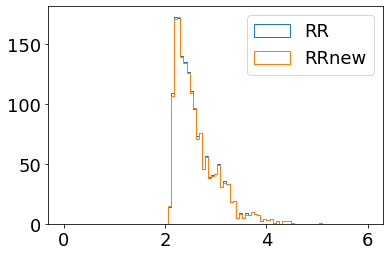

In [9]:
## Test RR
dv_max = 6000 #km/s
bins = np.linspace(0.0,6.0,100)
for c in ['RR','RRnew']:
    zgood = ((data_table['Z_VI']>-1) & 
             (abs(data_table['Z_{}'.format(c)]-data_table['Z_VI']) < dv_max*(1+data_table['Z_VI'])/300000.))
    #w = data_table['ISQSO_VI'] & data_table['ISQSO_{}'.format(c)] & (~zgood) & (data_table['Z_{}'.format(c)]>=2.1)
    #w = (((~data_table['ISQSO_{}'.format(c)]) | (data_table['ISQSO_{}'.format(c)] & (data_table['Z_{}'.format(c)]<2.1)))
    #     & (data_table['ISQSO_VI'] & (data_table['Z_VI']>=2.1)))
    w = ((data_table['ISQSO_{}'.format(c)] & (data_table['Z_{}'.format(c)]>=2.1))
         & (data_table['ISQSO_VI'] & (data_table['Z_VI']>=2.1)))
    wtrue = (data_table['ISQSO_VI'] & (data_table['Z_VI']>=2.1))
    print('{} finds {:2.2%} high-z QSOs ({}/{})'.format(c,w.sum()/wtrue.sum(),w.sum(),wtrue.sum()))
    plt.hist(data_table['Z_VI'][w],bins=bins,histtype='step',label=c)
plt.legend()
plt.show()

### Evaluate performance of classifiers at selecting for reobservation.
xxx

In [13]:
def make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=2.1):
    
    # determine the true classifications
    isqso_truth = (data_table['ISQSO_VI'])
    isgal_truth = (data_table['CLASS_VI']=='GALAXY')
    isbad = ((data_table['CLASS_VI']=='BAD') | (data_table['ZCONF_PERSON']!=2))
    zgood = (data_table['Z_VI']>0) & (abs(data_table['Z_QN']-data_table['Z_VI']) < dv_max*(1+data_table['Z_VI'])/300000.)
    highz_truth = data_table['Z_VI']>=zcut
    nhighz_truth = (isqso_truth & highz_truth).sum()

    for s in strategies.keys():
        if ('QN' in s) & ('SQ' in s):
            pass
        
        elif ('QN' in s) | ('SQ' in s):
            for i,cth in enumerate(c_th):
                strategies[s]['nhighz_flagged'][i] = (strategies[s]['w'][i]).sum()
                strategies[s]['nhighz_truth_flagged'][i] = (isqso_truth&highz_truth&strategies[s]['w'][i]).sum()

        else:
            strategies[s]['nhighz_flagged'][0] = (strategies[s]['w'][0]).sum()
            strategies[s]['nhighz_truth_flagged'][0] = (isqso_truth&highz_truth&strategies[s]['w'][0]).sum()

    for s in strategies.keys():
        reobs_dens = strategies[s]['nhighz_flagged']/eff_area
        pli = strategies[s]['nhighz_truth_flagged']/nhighz_truth
        if len(reobs_dens)>1:
            ax.plot(reobs_dens,pli,c='grey',marker=strategies[s]['marker'],label=s,zorder=2)
            points = ax.scatter(reobs_dens,pli,c=strategies[s]['color'],marker=strategies[s]['marker'],s=100,zorder=3)
        else:
            print(s,reobs_dens,pli)
            points = ax.scatter(reobs_dens,pli,c=strategies[s]['color'],marker=strategies[s]['marker'],s=100,label=s,zorder=3)

    # Colour bar
    fig.subplots_adjust(right=0.87)
    cbar_ax = fig.add_axes([0.89, 0.15, 0.02, 0.7])
    cb = fig.colorbar(points,label=r'$c_{th}$',cax=cbar_ax)
    cb.mappable.set_clim(vmin=cth_min,vmax=cth_max)

    ax.axvline(x=n_highz_desi,c='k',zorder=1,ls='--')
    #text = 'assumed number density of\n'+r'high-$z$ QSOs in DESI [sqd$^{-1}$]'
    #ax.text(50.,1.004,text,va='center',ha='center')

    ax.set_ylabel(r'fraction of high-$z$ QSOs reobserved')
    ax.set_xlim(47,52.0)
    ax.set_ylim(0.94,1.00)
    ax.grid()
    ax.legend(loc=4,ncol=1)
    ax.set_xlabel(r'number density of fibers allocated to reobservations [sqd$^{-1}$]')
    ax.set_axisbelow(True)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))

    # Shaded region.
    x = np.linspace(n_highz_desi*0.5,n_highz_desi*1.5,101)
    y = x/n_highz_desi
    y[x>n_highz_desi] = 1.
    ax.fill_between(x,y,np.ones_like(y)*1.1,edgecolor='darkgrey',facecolor='none',hatch='\\')

    """# Dashed lines for purities.
    p_values = [0.99,0.98,0.97,0.96,0.95]
    for p in p_values:
        p_contour = (x/50)*(p)
        ax.plot(x,p_contour,c='darkgrey')"""
    
    #plt.tight_layout()
    fig.subplots_adjust(wspace=0.1)
    plt.savefig(filename)
    plt.show()

    return

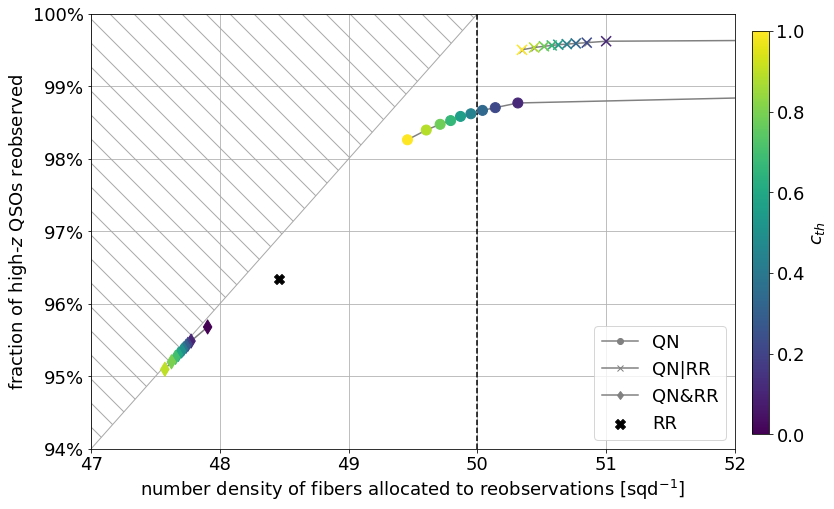

In [69]:
## Standard version of plot

# Number of expected high-z QSOs per square degree in DESI
n_highz_desi = 50
eff_area = ((data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>=2.1)).sum())/n_highz_desi

# Cut to define high-z QSOs.
zcut = 2.1
# Maximum velocity error to be considered a correct classification.
dv_max = 6000. # km/s

# QN confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut

# RR classifications.
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(data_table['Z_QN']>zcut) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['QN|RR'] = {'w': [w|(isqso_rr & highz_rr) for w in strategies['QN']['w']],
                       'nhighz_flagged': np.zeros(c_th.shape),
                       'nhighz_truth_flagged': np.zeros(c_th.shape),
                       'color': c_th,
                       'marker': 'x',
                      }

strategies['QN&RR'] = {'w': [w&(isqso_rr & highz_rr) for w in strategies['QN']['w']],
                       'nhighz_flagged': np.zeros(c_th.shape),
                       'nhighz_truth_flagged': np.zeros(c_th.shape),
                       'color': c_th,
                       'marker': 'd',
                      }

# Make the plot.
filename = '../plots/classifier_performance_selecting_for_reobservation.pdf'
fig, ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=zcut)

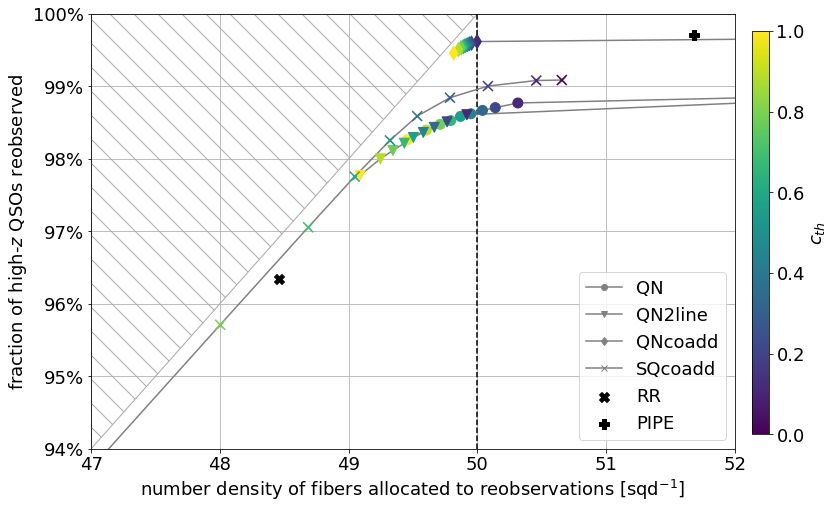

In [70]:
## Extra strategies version of plot

# Number of expected high-z QSOs per square degree in DESI
n_highz_desi = 50
eff_area = ((data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>=2.1)).sum())/n_highz_desi

# Cut to define high-z QSOs.
zcut = 2.1
# Maximum velocity error to be considered a correct classification.
dv_max = 6000. # km/s

# QN confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

# RR classifications.
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# PIPE classifications.
isqso_pipe = data_table['ISQSO_PIPE']
highz_pipe = data_table['Z_PIPE']>=zcut

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut
highz_qncoadd = data_table['Z_QNcoadd']>=zcut

# SQ classifications.
highz_sqcoadd = data_table['Z_SQcoadd']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(highz_qn) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['PIPE'] = {'w': [isqso_pipe & highz_pipe],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'P',
                   }

strategies['QN2line'] = {'w': [(data_table['CMAX_QN']>cth)&(data_table['CMAX2_QN']>cth)&(highz_qn) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'v',
                   }

strategies['QNcoadd'] = {'w': [(data_table['CMAX_QNcoadd']>cth)&(highz_qncoadd) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'd',
                   }

strategies['SQcoadd'] = {'w': [(data_table['P_SQcoadd']>cth)&(highz_sqcoadd) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'x',
                    }

# Make the plot.
filename = '../plots/classifier_performance_selecting_for_reobservation_extrastrat.pdf'
fig, ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=zcut)

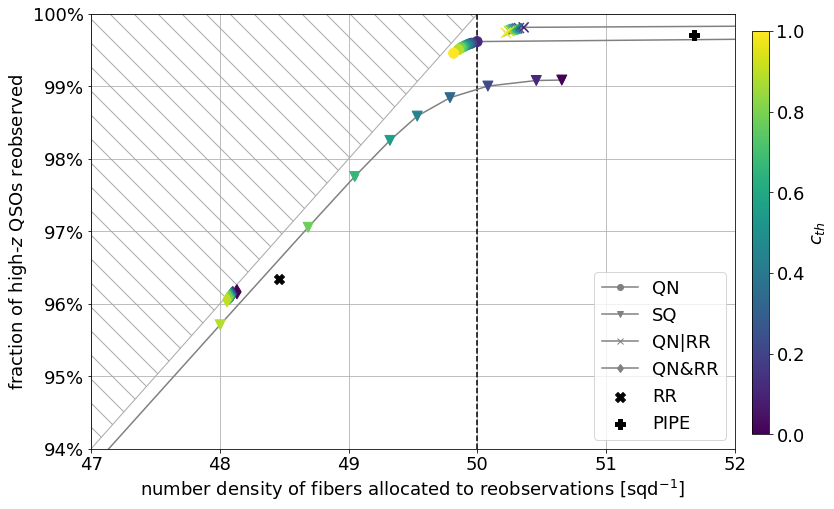

In [71]:
## Coadd only version of plot

# Number of expected high-z QSOs per square degree in DESI
n_highz_desi = 50
eff_area = ((data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>=2.1)).sum())/n_highz_desi

# Cut to define high-z QSOs.
zcut = 2.1
# Maximum velocity error to be considered a correct classification.
dv_max = 6000. # km/s

# QN confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

# RR classifications.
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# PIPE classifications.
isqso_pipe = data_table['ISQSO_PIPE']
highz_pipe = data_table['Z_PIPE']>=zcut

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut
highz_qncoadd = data_table['Z_QNcoadd']>=zcut

# SQ classifications.
highz_sqcoadd = data_table['Z_SQcoadd']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QNcoadd']>cth)&(highz_qncoadd) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['PIPE'] = {'w': [isqso_pipe & highz_pipe],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'P',
                   }

strategies['SQ'] = {'w': [(data_table['P_SQcoadd']>cth)&(highz_sqcoadd) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'v',
                    }

strategies['QN|RR'] = {'w': [w|(isqso_rr & highz_rr) for w in strategies['QN']['w']],
                       'nhighz_flagged': np.zeros(c_th.shape),
                       'nhighz_truth_flagged': np.zeros(c_th.shape),
                       'color': c_th,
                       'marker': 'x',
                      }

strategies['QN&RR'] = {'w': [w&(isqso_rr & highz_rr) for w in strategies['QN']['w']],
                       'nhighz_flagged': np.zeros(c_th.shape),
                       'nhighz_truth_flagged': np.zeros(c_th.shape),
                       'color': c_th,
                       'marker': 'd',
                      }
# Make the plot.
filename = '../plots/classifier_performance_selecting_for_reobservation_coadd.pdf'
fig, ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=zcut)

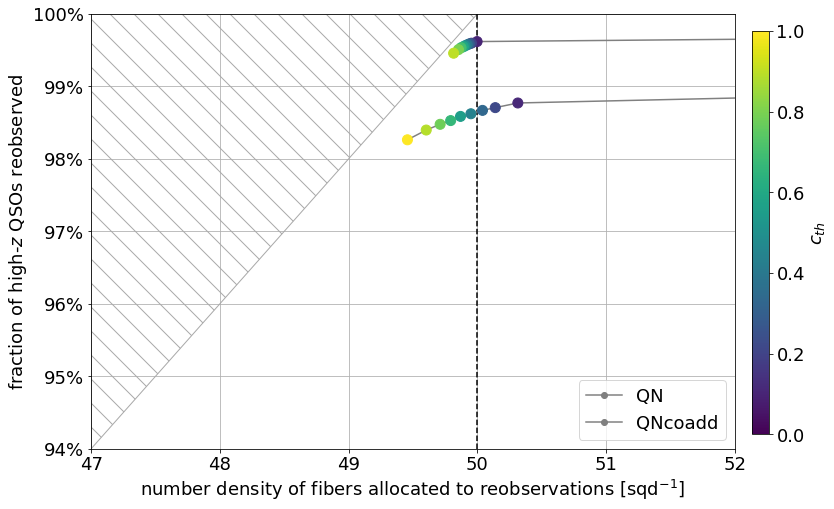

In [72]:
## QN coadd vs single exposure.

# Number of expected high-z QSOs per square degree in DESI
n_highz_desi = 50
eff_area = ((data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>=2.1)).sum())/n_highz_desi

# Cut to define high-z QSOs.
zcut = 2.1
# Maximum velocity error to be considered a correct classification.
dv_max = 6000. # km/s

# QN confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut
highz_qncoadd = data_table['Z_QNcoadd']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(highz_qn) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['QNcoadd'] = {'w': [(data_table['CMAX_QNcoadd']>cth)&(highz_qncoadd) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

# Make the plot.
filename = '../plots/classifier_performance_selecting_for_reobservation_qnonly.pdf'
fig, ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=zcut)

RR [48.7654321] [0.96632997]
RRnew [48.06397306] [0.95679012]
RRbe [39.8989899] [0.79685746]
RRre0 [39.47811448] [0.78731762]
RRre1 [39.1694725] [0.78282828]


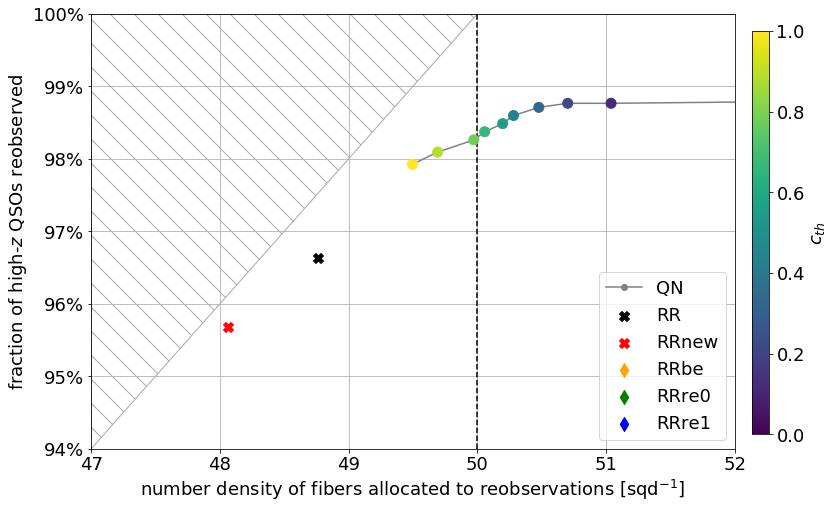

In [14]:
## Compare redrock version of plot

# Number of expected high-z QSOs per square degree in DESI
n_highz_desi = 50
eff_area = ((data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>=2.1)).sum())/n_highz_desi

# Cut to define high-z QSOs.
zcut = 2.1
# Maximum velocity error to be considered a correct classification.
dv_max = 6000. # km/s

# QN confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut

# RR classifications.
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# RRnew classifications.
isqso_rrnew = data_table['ISQSO_RRnew']
highz_rrnew = data_table['Z_RRnew']>=zcut

# RRnew classifications.
isqso_rrbe = data_table['ISQSO_RRbe']
highz_rrbe = data_table['Z_RRbe']>=zcut

# RRnew classifications.
isqso_rrre0 = data_table['ISQSO_RRre0']
highz_rrre0 = data_table['Z_RRre0']>=zcut

# RRnew classifications.
isqso_rrre1 = data_table['ISQSO_RRre1']
highz_rrre1 = data_table['Z_RRre1']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(data_table['Z_QN']>zcut) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['RRnew'] = {'w': [isqso_rrnew & highz_rrnew],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'red',
                    'marker': 'X',
                   }

strategies['RRbe'] = {'w': [isqso_rrbe & highz_rrbe],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'orange',
                    'marker': 'd',
                   }

strategies['RRre0'] = {'w': [isqso_rrre0 & highz_rrre0],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'green',
                    'marker': 'd',
                   }

strategies['RRre1'] = {'w': [isqso_rrre1 & highz_rrre1],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'blue',
                    'marker': 'd',
                   }

# Make the plot.
filename = '../plots/classifier_performance_selecting_for_reobservation_rrtest.pdf'
fig, ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=zcut)